This sheet is TESTING for one science image and one ref image. In this version, we're going to let Swarp do *all* the rotation, since maybe it's our crappy rotation scheme that's screwing this up.

Ok so this here sheet is going to be the full image subtraction routine for SN photometry. Note that it is being written to be applied to a single filter at a time, for simplicity!

Note that following the original script from GROWTH 2020, this script will remove the processed directories when you run it, so careful!

Also note that we assume the images have already been rotated (via that script), and have a valid WCS. I've included the WCS routine in the rotation sheet, so we should be good there.

The source directory should contain just the rotated source images. The data directory will be created by this code as the sources images + conifguration files, and the processed directory will be....the processed directory! This is awkward, but can't really figure out how to make it work otherwise...


Actually, this version is intended for use on a cropped image, but that's done in the rotation script, so no major changes here (except to determine the size of the images dynamically).

Now THIS version is going to subtract just a region around the source.

First import relevant packages:

In [33]:
import os  #Call commands from outside Python
import numpy as np

# Running external programs
import subprocess
import shutil

from astropy.coordinates import SkyCoord # For the catalog analysis during normalization

from astropy.io import fits #FITS files handling
from astropy.io import ascii  #Read/write ascii files
from astropy.wcs import WCS # for the cropping routine


# Background subtraction
import photutils
#from photutils.detection import DAOStarFinder
from photutils.segmentation import detect_threshold, detect_sources
#from photutils import Background2D, MedianBackground # old version
from photutils.background import Background2D, MedianBackground 
from astropy.stats import sigma_clipped_stats, SigmaClip # statistics
from photutils.utils import circular_footprint

# Image registration and shifting
from image_registration import chi2_shift
from image_registration.fft_tools import shift
import scipy
from scipy import ndimage, misc

# Useful to smooth the images with a Gaussian kernel before the subtraction
from scipy.signal import convolve as scipy_convolve

# For rotation
import astroalign as aa

# Plot
import matplotlib.pyplot as plt

# Math help
import math

In [2]:
# Set directory structure
cwd = os.getcwd()

print("You start from the directory:", cwd)

source_dir = os.path.join(cwd, 'source') # All the stacked, rotated files should be in here
data_dir = os.path.join(cwd, 'data') # empty, but will get rewritten.
if os.path.isdir(data_dir): # checks and removes if it exists. 
    shutil.rmtree(data_dir)
os.mkdir(data_dir)
proc_dir = os.path.join(cwd, 'processed') # all processes fits files.
out_dir = os.path.join(proc_dir, 'out') # output files are here
if os.path.isdir(proc_dir): # checks and removes if it exists. 
    shutil.rmtree(proc_dir)
os.mkdir(proc_dir)
config_dir = os.path.join(cwd, 'config') # various configuration files, should exist!
if os.path.exists(config_dir)==False:
    print("Error, config directory does not exist!")
    raise

for f in os.listdir(source_dir): # copy sources into data directory.
    shutil.copy2(os.path.join(source_dir, f), os.path.join(data_dir,f))
for f in os.listdir(config_dir): # copy configuration into data directory.
    shutil.copy2(os.path.join(config_dir, f), data_dir)
for f in os.listdir(data_dir): # copy data into processed and change to it.
    shutil.copy2(os.path.join(data_dir, f), proc_dir)

os.chdir(proc_dir)
print("You are working in the image_subtraction/processed/ directory: ")
print("Full path:", proc_dir)

You start from the directory: /home/cduston/GoogleDrive/Research/MCARG/Novae/SN2023ctn/image_subtraction
You are working in the image_subtraction/processed/ directory: 
Full path: /home/cduston/GoogleDrive/Research/MCARG/Novae/SN2023ctn/image_subtraction/processed


Need to get the list of rotated images (since that used to be part of this script!)

In [3]:
rot_name_array=[]
for f in os.listdir(source_dir): # create list of raw images
    rot_name_array.append(f)
    
rot_name_array.sort() # sorted by name so that discovery is first.
rot_name_array

['SUM_Aligned_20230308_I.fits',
 'SUM_Aligned_20230309_I.fits',
 'SUM_Aligned_20230310_I.fits',
 'SUM_Aligned_20230311_I.fits',
 'SUM_Aligned_20230312_I.fits',
 'SUM_Aligned_20230313_I.fits',
 'SUM_Aligned_20240116_I.fits',
 'SUM_Aligned_20240119_I.fits']

## Subtraction Routine

This part comes from the GROWTH 2020 school, with my own modifications and dealing with some recent changes to the code. We'll start with a dependency check:

(for now skipping all reference to ds9, since that doesn't actually seem that useful atm.)

the rest of this is for FAILED Slackware installation!

installing these things was kind of a nightmare...these instructions are for Slackware...

Swarp: https://www.astromatic.net/software download source. run autogen? ./configure, make, su, make install...

SExtractor https://www.astromatic.net/software source....will need ATLAS and FFTW. trying autogen. ATLAS not in 15.0 yet! Guess I'll switch to System76 and try old Slackbuilds. Ugh ATLAS does not seem to build on Slack 15.0 (email thread). Trying the intel MKL approach...following wget instructions from https://www.intel.com/content/www/us/en/developer/tools/oneapi/base-toolkit-download.html?operatingsystem=linux&distributions=offline. Compatibility warnings, proceeding...isntall location /opt/intel/oneapi. Failing lots of prereqs. All gui, so just pushing forward. Skip eclipse. Need g++, but I actually have that installed, it just can't find it. continuing...says done. trying to configure with --enable-mkl, but cannot find c compilter. 

ATLAS alone does not seem to build either on Slackware.....bust!

In [4]:
def test_dependency(dep, alternate_name=None):
    """
    Test external dependency by trying to run it as a subprocess
    """
    try:
        subprocess.check_output(dep, stderr=subprocess.PIPE, shell=True)
        print("%s is installed properly as %s. OK" % (dep, dep))
        return 1
    except subprocess.CalledProcessError:
        try:
            subprocess.check_output(alternate_name, stderr=subprocess.PIPE, shell=True)
            print("%s is installed properly as %s. OK" % (dep, alternate_name))
            return 1
        except subprocess.CalledProcessError:
            print("===%s/%s IS NOT YET INSTALLED PROPERLY===" % (dep, alternate_name))
            return 0

#dependencies = [('sextractor', 'sex'), ('SWarp', 'swarp'), ('psfex', 'PSFEx'), ('ds9', 'DS9')]
#dependencies = [('sextractor', 'source-extractor'), ('SWarp', 'swarp'), ('psfex', 'PSFEx'), ('ds9', 'DS9')]
dependencies = [('sextractor', 'source-extractor'), ('SWarp', 'swarp'), ('psfex', 'PSFEx')]
i = 0
for dep_name1, dep_name2 in dependencies:
    i += test_dependency(dep_name1, dep_name2)
print("%i out of %i external dependencies installed properly.\n" % (i, len(dependencies)))
if i != len(dependencies):
    print("Please correctly install these programs before continuing by following the instructions in README.md.")
else:
    print("You are ready to continue.")   

sextractor is installed properly as source-extractor. OK
SWarp is installed properly as swarp. OK
psfex is installed properly as psfex. OK
3 out of 3 external dependencies installed properly.

You are ready to continue.


## Align the images

Use the AstrOmatic Swarp package to align the images.  Swarp relies on the astrometric information of the image (in other words, on the sky coordinates), therefore both the science and reference images must be astrometrically calibrated (for example, using the AstrOmatic SCAMP package).  In this module we assume that the input images are already calibrated.

We should be trying to pass the entire list to swarp at once, methinks.

In [5]:
'''
# rot_image_array=[]
swarp_filelist_name=config_dir+"/"+'swarp_filelist.txt'
swarp_filelist = open(swarp_filelist_name, 'w')
for f in rot_name_array: 
    #rot_image_array.append(f)
    print(f)
    swarp_filelist.write(str(f) + "\n")
swarp_filelist.close()
'''

'\n# rot_image_array=[]\nswarp_filelist_name=config_dir+"/"+\'swarp_filelist.txt\'\nswarp_filelist = open(swarp_filelist_name, \'w\')\nfor f in rot_name_array: \n    #rot_image_array.append(f)\n    print(f)\n    swarp_filelist.write(str(f) + "\n")\nswarp_filelist.close()\n'

In [6]:
# grab a single science image and reference
sci_image_name=rot_name_array[0]
print(sci_image_name)
#ref_image_name=rot_name_array[1] # As a test, doing two science images!
ref_image_name=rot_name_array[len(rot_name_array)-1]
print(ref_image_name)

SUM_Aligned_20230308_I.fits
SUM_Aligned_20240119_I.fits


In [7]:
'''
# swap the emden-ness (might not be needed...)
sci_image=fits.open(sci_image_name)
sci_image_data = sci_image[0].data
sci = sci_image_data.byteswap().newbyteorder()
sci_hdu = fits.PrimaryHDU(sci,sci_image[0].header) #added headers!
sci_hdu.writeto(sci_image_name,overwrite=True)

ref_image=fits.open(ref_image_name)
ref_image_data = ref_image[0].data
ref = ref_image_data.byteswap().newbyteorder()
ref_hdu = fits.PrimaryHDU(ref,ref_image[0].header) #added headers!
ref_hdu.writeto(ref_image_name,overwrite=True)
'''

'\n# swap the emden-ness (might not be needed...)\nsci_image=fits.open(sci_image_name)\nsci_image_data = sci_image[0].data\nsci = sci_image_data.byteswap().newbyteorder()\nsci_hdu = fits.PrimaryHDU(sci,sci_image[0].header) #added headers!\nsci_hdu.writeto(sci_image_name,overwrite=True)\n\nref_image=fits.open(ref_image_name)\nref_image_data = ref_image[0].data\nref = ref_image_data.byteswap().newbyteorder()\nref_hdu = fits.PrimaryHDU(ref,ref_image[0].header) #added headers!\nref_hdu.writeto(ref_image_name,overwrite=True)\n'

Note in this next command the size of the box is basically dummy for right now, but it does crop the images (unessicarily, I think). Should just be square at least...

In [8]:
'''
# Swarp command
# had to change capitalization of SWarp!
try:
    #command = "swarp %s %s -c %s -SUBTRACT_BACK N -RESAMPLE Y -RESAMPLE_DIR . -COMBINE N -IMAGE_SIZE 1800,900" % (sci_image_name, ref_image_name, os.path.join(config_dir, 'config.swarp'))
    command = "swarp @%s -c %s -SUBTRACT_BACK N -RESAMPLE Y -RESAMPLE_DIR . -COMBINE N -IMAGE_SIZE 1800,900" % (swarp_filelist_name, os.path.join(config_dir, 'config.swarp'))
    print('Executing command: %s' % command)
    rval = subprocess.run(command.split(), check=True)
    print('Success!')
except subprocess.CalledProcessError as err:
    print('Could not run SWarp with exit error %s'%err)

# Gotta fix the names of the aligned images
swarp_filelist = open(swarp_filelist_name, 'r')
align_image_array=[]
for line in swarp_filelist:
    #print(line)
    align_image_array.append(line.strip().replace(".fits", ".resamp.fits").replace('data','processed'))
#sci_image_aligned_name = sci_image_name.replace(".fits", ".resamp.fits").replace('data','processed')
#ref_image_aligned_name = ref_image_name.replace(".fits", ".resamp.fits").replace('data','processed')
swarp_filelist.close()
'''

'\n# Swarp command\n# had to change capitalization of SWarp!\ntry:\n    #command = "swarp %s %s -c %s -SUBTRACT_BACK N -RESAMPLE Y -RESAMPLE_DIR . -COMBINE N -IMAGE_SIZE 1800,900" % (sci_image_name, ref_image_name, os.path.join(config_dir, \'config.swarp\'))\n    command = "swarp @%s -c %s -SUBTRACT_BACK N -RESAMPLE Y -RESAMPLE_DIR . -COMBINE N -IMAGE_SIZE 1800,900" % (swarp_filelist_name, os.path.join(config_dir, \'config.swarp\'))\n    print(\'Executing command: %s\' % command)\n    rval = subprocess.run(command.split(), check=True)\n    print(\'Success!\')\nexcept subprocess.CalledProcessError as err:\n    print(\'Could not run SWarp with exit error %s\'%err)\n\n# Gotta fix the names of the aligned images\nswarp_filelist = open(swarp_filelist_name, \'r\')\nalign_image_array=[]\nfor line in swarp_filelist:\n    #print(line)\n    align_image_array.append(line.strip().replace(".fits", ".resamp.fits").replace(\'data\',\'processed\'))\n#sci_image_aligned_name = sci_image_name.replace(".f

In [9]:
os.getcwd()

'/home/cduston/GoogleDrive/Research/MCARG/Novae/SN2023ctn/image_subtraction/processed'

In [10]:
# single swarp command:
# Determmine image size...
# No, Swarp is resampling, so WE set the image size.

#ref_image = fits.open(ref_image_name)
#ref_hdr = ref_image[0].header
#XSIZE=ref_hdr['NAXIS1']-10# could be wrong order!
XSIZE=1800
YSIZE=900
#YSIZE=ref_hdr['NAXIS2']-10
#print("Image sizes:",XSIZE,YSIZE)
#ref_image.close()

try:
    #command = "swarp %s %s -c %s -SUBTRACT_BACK N -RESAMPLE Y -RESAMPLE_DIR . -COMBINE N" % (sci_image_name, ref_image_name, os.path.join(config_dir, 'config.swarp'))
    command = "swarp %s %s -c %s -SUBTRACT_BACK N -RESAMPLE Y -RESAMPLE_DIR . -COMBINE N -IMAGE_SIZE 1800,900" % (sci_image_name,ref_image_name, os.path.join(config_dir, 'config.swarp'))
    #command = "swarp @%s -c %s -SUBTRACT_BACK N -RESAMPLE Y -RESAMPLE_DIR . -COMBINE N -IMAGE_SIZE 1800,900" % (swarp_filelist_name, os.path.join(config_dir, 'config.swarp'))
    print('Executing command: %s' % command)
    rval = subprocess.run(command.split(), check=True)
    print('Success!')
except subprocess.CalledProcessError as err:
    print('Could not run SWarp with exit error %s'%err)
    
sci_image_aligned_name = sci_image_name.replace(".fits", ".resamp.fits").replace('data','processed')
ref_image_aligned_name = ref_image_name.replace(".fits", ".resamp.fits").replace('data','processed')

Executing command: swarp SUM_Aligned_20230308_I.fits SUM_Aligned_20240119_I.fits -c /home/cduston/GoogleDrive/Research/MCARG/Novae/SN2023ctn/image_subtraction/config/config.swarp -SUBTRACT_BACK N -RESAMPLE Y -RESAMPLE_DIR . -COMBINE N -IMAGE_SIZE 1800,900
Success!


> 
----- SWarp 2.41.5 started on 2024-04-15 at 12:08:37 with 12 threads

> Examining input data ...
> Looking for SUM_Aligned_20230308_I.fits ...
> Looking for SUM_Aligned_20240119_I.fits ...
> Creating NEW output image ...
> Creating NEW weight-map ...
> 
------- Output File swarpout.fits:
    "no ident"  WEIGHTED  no ext. header  1800x900  32 bits (floats)
    Center: 08:32:59.91 -27:26:59.2   21.5'x10.8'  Scale: 0.7171 ''/pixel
    Gain: 0 e-/ADU   Flux scaling (astrom/photom): 1 X / 1 X

> Loading input data ...
> 
-------------- File SUM_Aligned_20230308_I.fits:
    "SN2023ctn"  unweighted  no ext. header  2250x1800  32 bits (floats)
    Center: 08:33:00.08 -27:26:59.3   26.9'x21.5'  Scale: 0.7169 ''/pixel
    Gain: 4 e-/ADU   Flux scaling (astrom/photom): 1.001 X / 1 X
> Setting up background maps ...
> Setting up background map at line:    512 / 1800   
> Setting up background map at line:   1024 / 1800   
> Setting up background map at line:   1536 / 1800   
> Filtering backgro

In [11]:
'''
align_image_array
'''

'\nalign_image_array\n'

And AstroImageJ verifies this basically looks right - but notice again the cropping might not make that such sense.

I think for debug, let's try to subtract two images right here. Altohugh note that there is another refinement step later, so even if bad here, maybe don't care?

In [12]:
ref_image_aligned_name

'SUM_Aligned_20240119_I.resamp.fits'

In [13]:
sci_image_aligned_name

'SUM_Aligned_20230308_I.resamp.fits'

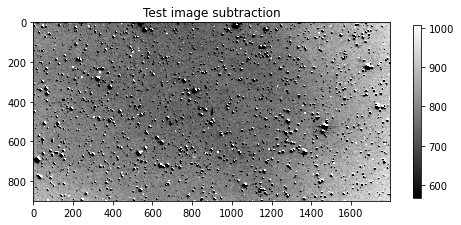

In [14]:
# Test image subtract - SINGLE IMAGE TEST ONLY!
ref_image_aligned = fits.open(ref_image_aligned_name)
hdr_ref = ref_image_aligned[0].header #save fits header
sci_image_aligned = fits.open(sci_image_aligned_name)
hdr_sci = sci_image_aligned[0].header #save fits header

# Perform the image subtraction
# looks like creating a new fits image, so going back to that tutorial....
image_sub = sci_image_aligned[0].data - ref_image_aligned[0].data
hdu_image_sub = fits.PrimaryHDU(image_sub)
hdu_image_sub.writeto("sub_test_0.fits", overwrite = True)

# Plot up the result of the image subtraction
mean, median, std = sigma_clipped_stats(hdu_image_sub.data)
plt.figure(figsize=(8,8))

# Set the scale of the image based on its statistics
plt.imshow(hdu_image_sub.data, vmin=median-2*std, vmax=median+2*std, cmap='gray')
plt.colorbar(shrink=0.4)
plt.title('Test image subtraction')
plt.show()

Might actually look better than their example...but ok, just not perfectly aligned.



# Background Subtraction
- Mask sources in images
- Use 3 sigma clipping to filter data and accurately measure the backgorund
- Then split image into 300x300 pixel boxes and apply 2x2 median filter

That was the original. We are going to (for the first image)

1) look at the scalar background
2) look at the 2D background with no mask
3) look at the 2D background a mask

And then assume (3) is best and go ahead with subtracting them all!

In [15]:

# Eventually do this for each image in the array.
image = sci_image_aligned # remove for multi image!
#image = fits.open(align_image_array[0])
hdr = image[0].header #save fits header

#estimate scalar background with sourcemask
sigma_clip = SigmaClip(sigma=3.0, maxiters=10)
threshold = detect_threshold(image[0].data, nsigma=2.0, sigma_clip=sigma_clip)
segment_img = detect_sources(image[0].data, threshold, npixels=10)
footprint = circular_footprint(radius=10) #watch this footprint value, should be inspected!
mask = segment_img.make_source_mask(footprint=footprint)
mean, median, std = sigma_clipped_stats(image[0].data, sigma=3.0, mask=mask)
print((mean, median, std))  

(2866.329, 2865.2102, 76.08629)


Somehow we should evaluate that...

ok but I think for real we just SKIP those scalar, and go right for the 2D background estimator (50x50 box, 3x3 median filter). First image first.

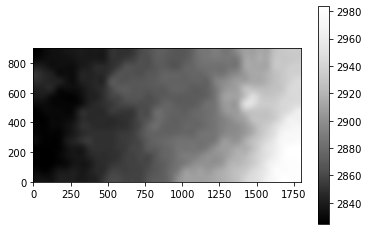

In [16]:
bkg_estimator = MedianBackground()
sigma_clip = SigmaClip(sigma=3.0)
bkg = Background2D(image[0].data, (50, 50), filter_size=(3, 3),sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
plt.imshow(bkg.background, origin='lower', cmap='Greys_r',interpolation='nearest')
plt.colorbar()

I suppose there is some effect of the background stars here - since we are not doing any masking. Let's try the same mask from above, and see if it gets any better?

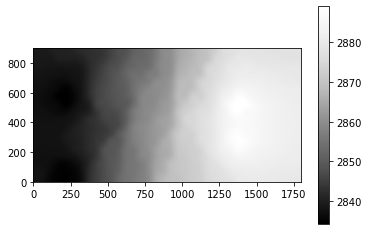

In [17]:
bkg = Background2D(image[0].data, (50, 50), filter_size=(3, 3),sigma_clip=sigma_clip, bkg_estimator=bkg_estimator,mask=mask)
plt.imshow(bkg.background, origin='lower', cmap='Greys_r',interpolation='nearest')
plt.colorbar()

yyyeaahh I guess that's better, the background should probably be NOT bumpy at all. So use this and background subtract everything.

(Background goes negative here, I had real problems in AIJ with that....)

In [18]:
# Just do this twice for the single image test!
# measure and subtract the background for science image
bkg = Background2D(image[0].data, (50, 50), filter_size=(3, 3),sigma_clip=sigma_clip, bkg_estimator=bkg_estimator,mask=mask)
sci_bkg_subtract_name=sci_image_aligned_name.replace(".resamp.fits", "_bkgsub.fits")
image[0].data = image[0].data - bkg.background
hdu_image_sub = fits.PrimaryHDU(image[0].data,image[0].header) #added headers!
hdu_image_sub.writeto(sci_bkg_subtract_name,overwrite=True)
# measure and subtract the background for reference image
image = ref_image_aligned
bkg = Background2D(image[0].data, (50, 50), filter_size=(3, 3),sigma_clip=sigma_clip, bkg_estimator=bkg_estimator,mask=mask)
ref_bkg_subtract_name=ref_image_aligned_name.replace(".resamp.fits", "_bkgsub.fits")
image[0].data = image[0].data - bkg.background
hdu_image_sub = fits.PrimaryHDU(image[0].data,image[0].header) #added headers!
hdu_image_sub.writeto(ref_bkg_subtract_name,overwrite=True)

# Check those in AIJ: both seem kinda background-subtracted! (zero or below!)

In [19]:
'''
# Do this for each image in the array.
bkg_subtract_array=[]
for i in range(len(align_image_array)):
    image = fits.open(align_image_array[i])
    hdr = image[0].header #save fits header
    # measure and subtract the background
    bkg = Background2D(image[0].data, (50, 50), filter_size=(3, 3),sigma_clip=sigma_clip, bkg_estimator=bkg_estimator,mask=mask)
    bkg_subtract_name=align_image_array[i].replace(".resamp.fits", "_bkgsub.fits")
    bkg_subtract_array.append(bkg_subtract_name)
    image[0].data = image[0].data - bkg.background
    hdu_image_sub = fits.PrimaryHDU(image[0].data,image[0].header) #added headers!
    hdu_image_sub.writeto(bkg_subtract_name,overwrite=True)
'''

'\n# Do this for each image in the array.\nbkg_subtract_array=[]\nfor i in range(len(align_image_array)):\n    image = fits.open(align_image_array[i])\n    hdr = image[0].header #save fits header\n    # measure and subtract the background\n    bkg = Background2D(image[0].data, (50, 50), filter_size=(3, 3),sigma_clip=sigma_clip, bkg_estimator=bkg_estimator,mask=mask)\n    bkg_subtract_name=align_image_array[i].replace(".resamp.fits", "_bkgsub.fits")\n    bkg_subtract_array.append(bkg_subtract_name)\n    image[0].data = image[0].data - bkg.background\n    hdu_image_sub = fits.PrimaryHDU(image[0].data,image[0].header) #added headers!\n    hdu_image_sub.writeto(bkg_subtract_name,overwrite=True)\n'

These images look right, but I did get an error that these images are now double precision, whereas AIJ expects single precision. Fine for now?


In [20]:
'''
bkg_subtract_array
'''

'\nbkg_subtract_array\n'

## PSF matching

The atmosphere heavily affects the PSF of the images by determining the "seeing" conditions. The seeing for ground-based optical telescopes is usually measured as the FWHM of the imaging PSF.  Properties of the atmosphere can change very rapidly, so it is rare that science and reference images are characterized by the same seeing. Therefore their PSFs are usually different, which is a problem for image subtraction. 


### Generate the kernel for the convolution

The PSF of the science and reference images can be matched in several different ways.  Here we start by performing a first source extraction on the reference image (which we assume to be the last in the list).  We can use the catalogs of sources that we obtain for two main purposes: <br />
1. Measure the PSF of the science (reference?) frame, using PSFex or photutils
2. Obtain instruments magnitudes that will be the basis for the zero-point calibration (see Photometry module).  


In [21]:
#bkg_subtract_array[len(bkg_subtract_array)-1]

In [22]:
# use REFERENCE image to extract sources.
# overwriting the catalog, but I guess that doesn't matter much.

ref_image_bkgsub_name = ref_bkg_subtract_name # SWTICH when you go back to multi image!
#ref_image_bkgsub_name = os.path.join(proc_dir, bkg_subtract_array[len(bkg_subtract_array)-1])

if os.path.exists('prepsfex.cat'): #Remove possible temporary files
    os.remove("prepsfex.cat") 

try:
    #command = "sextractor %s -c %s -CATALOG_NAME %s -MAG_ZEROPOINT 25.0" % (sci_image_aligned_name, os.path.join(data_dir, 'prepsfex.sex'), os.path.join(proc_dir, 'prepsfex.cat'))
    #command = "source-extractor %s -c %s -CATALOG_NAME %s -MAG_ZEROPOINT 25.0" % (sci_image_aligned_name, os.path.join(data_dir, 'prepsfex.sex'), os.path.join(proc_dir, 'prepsfex.cat'))
    command = "source-extractor %s -c %s -CATALOG_NAME %s -MAG_ZEROPOINT 25.0" % (ref_image_bkgsub_name, os.path.join(data_dir,'prepsfex.sex'), os.path.join(proc_dir, 'prepsfex.cat'))
    print('Executing command: %s\n' % command)
    rval = subprocess.run(command.split(), check=True)
    print('Success!')
except subprocess.CalledProcessError as err:
    print('Could not run SExtractor with exit error %s'%err)

Executing command: source-extractor SUM_Aligned_20240119_I_bkgsub.fits -c /home/cduston/GoogleDrive/Research/MCARG/Novae/SN2023ctn/image_subtraction/data/prepsfex.sex -CATALOG_NAME /home/cduston/GoogleDrive/Research/MCARG/Novae/SN2023ctn/image_subtraction/processed/prepsfex.cat -MAG_ZEROPOINT 25.0

Success!


Now we use another software part of the AstrOmatic suite, PSFex, to **measure the PSF of the reference image(s)**. PSFex estimates the PSF based on the information present in the catalog generated with SExtractor.  Then, let's plot the PSF model obtained with PSFex

Executing command: psfex prepsfex.cat -c psfex_conf.psfex




> WARNING: NTHREADS != 1 ignored: this build of PSFEx is single-threaded



Success!
/home/cduston/GoogleDrive/Research/MCARG/Novae/SN2023ctn/image_subtraction/processed/out/proto_prepsfex.fits



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.



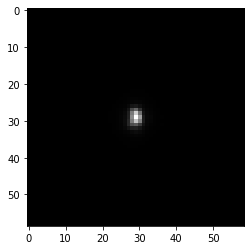

In [23]:
# Run PSFex to compute PSF, read and display the final model; needs to output to "out" dir.
if not os.path.isdir('out'): os.mkdir('out')

try:
    command = "psfex prepsfex.cat -c psfex_conf.psfex"
    #command = "psfex %s -c %s" % (source_extract_cat_name,psfex_config_name)
    print('Executing command: %s\n' % command)
    rval = subprocess.run(command.split(), check=True)
    print('Success!')
except subprocess.CalledProcessError as err:
    print('Could not run psfex with exit error %s'%err)

psf_ref_image_name = os.path.join(out_dir,'proto_prepsfex.fits') # temporary name?
print(psf_ref_image_name)
psf_ref_image = fits.open(psf_ref_image_name)

plt.imshow(psf_ref_image[0].data[0], cmap='gray')

mostly round ball...as expected...

### Convolve the reference image with the PSF of each science image

Now that the kernel is generated, let's convolve the reference image with the PSF of each science frame.

In [24]:
'''
sci_bkg_subtract = fits.open(bkg_subtract_array[2])
sci_bkg_subtract[0].header
'''

'\nsci_bkg_subtract = fits.open(bkg_subtract_array[2])\nsci_bkg_subtract[0].header\n'

header is almost empty - in particular it's missing the WCS! (old comment?)

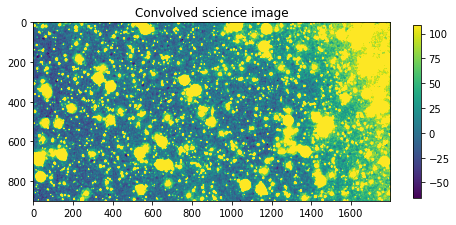

In [25]:
# this is to be deleted when we move to multi images, but notice the science and ref images might be 
# switched below, incorrectly!

# Convolve the kernel of the reference images with the PSF of the science frame
kernel_ref = psf_ref_image[0].data[0] # from the PSF we just did...

sci_bkg_subtract = fits.open(sci_bkg_subtract_name) # gross!
sci_conv = scipy_convolve(sci_bkg_subtract[0].data, kernel_ref, mode='same', method='fft') # convolve step
hdu_sci_conv = fits.PrimaryHDU(sci_conv,sci_bkg_subtract[0].header) 
sci_conv_name=os.path.join(proc_dir,sci_bkg_subtract_name.replace(".fits","_conv.fits"))
hdu_sci_conv.writeto(sci_conv_name,overwrite=True)

#Plot up the convolved reference image
mean, median, std = sigma_clipped_stats(hdu_sci_conv.data)
plt.figure(figsize=(8,8))

# set the scale of the image based on its statistics
plt.imshow(hdu_sci_conv.data, vmin=median-2*std, vmax=median+2*std)
plt.colorbar(shrink = 0.4)
plt.title('Convolved science image')
plt.show()

In [26]:
'''
# Convolve the kernel of the reference image with the PSF of the science frame
kernel_ref = psf_ref_image[0].data[0]

# for plotting
#fig, axes = plt.subplots(3, math.ceil(len(bkg_subtract_array)/3.))
#plt.figure(figsize=(4,4))

sci_conv_array=[]
for i in range(len(bkg_subtract_array)-1): # don't need to do the last one, that's reference
    sci_bkg_subtract = fits.open(bkg_subtract_array[i])
    sci_conv = scipy_convolve(sci_bkg_subtract[0].data, kernel_ref, mode='same', method='fft') # convolve step
    hdu_sci_conv = fits.PrimaryHDU(sci_conv,sci_bkg_subtract[0].header) # really should be adding header keys!
    sci_conv_array.append(bkg_subtract_array[i].replace(".fits","_conv.fits"))
    sci_conv_name=os.path.join(proc_dir,sci_conv_array[i])
    
    # Images not being created!
    print(sci_conv_name)
    hdu_sci_conv.writeto(sci_conv_name,overwrite=True)

    #Plot up the convolved reference image
    mean, median, std = sigma_clipped_stats(hdu_sci_conv.data)
    plt.figure(figsize=(8,8))

    # set the scale of the image based on its statistics
    # Name looks totally wrong!
    plt.imshow(sci_bkg_subtract[0].data, vmin=median-2*std, vmax=median+2*std)
    plt.colorbar(shrink = 0.4)
    plt.title('Convolved science image')
    plt.show()
'''

'\n# Convolve the kernel of the reference image with the PSF of the science frame\nkernel_ref = psf_ref_image[0].data[0]\n\n# for plotting\n#fig, axes = plt.subplots(3, math.ceil(len(bkg_subtract_array)/3.))\n#plt.figure(figsize=(4,4))\n\nsci_conv_array=[]\nfor i in range(len(bkg_subtract_array)-1): # don\'t need to do the last one, that\'s reference\n    sci_bkg_subtract = fits.open(bkg_subtract_array[i])\n    sci_conv = scipy_convolve(sci_bkg_subtract[0].data, kernel_ref, mode=\'same\', method=\'fft\') # convolve step\n    hdu_sci_conv = fits.PrimaryHDU(sci_conv,sci_bkg_subtract[0].header) # really should be adding header keys!\n    sci_conv_array.append(bkg_subtract_array[i].replace(".fits","_conv.fits"))\n    sci_conv_name=os.path.join(proc_dir,sci_conv_array[i])\n    \n    # Images not being created!\n    print(sci_conv_name)\n    hdu_sci_conv.writeto(sci_conv_name,overwrite=True)\n\n    #Plot up the convolved reference image\n    mean, median, std = sigma_clipped_stats(hdu_sci_co

Kinda hard to tell they are changing, but I think they are!

Next step is actually to create a refernce image for each science image, which is the reference convolved with the science. Then each pair should have the same PSF.

In [27]:
'''
sci_conv_array
'''

'\nsci_conv_array\n'

### Convolve the science image with the PSF of the reference image


Same as above, but this time we generate a kernel with the properties of the **PSF of the science image**.  Then, we convolve the reference image with this kernel.

I think what is happening here is the PSF data is stored in prepsfex.cat, as an output catalog from source-extractor, so we need to re-run the source extractor to get the PSF of the image in question.

Kernel from *each* science image

Executing command: source-extractor SUM_Aligned_20230308_I_bkgsub.fits -c /home/cduston/GoogleDrive/Research/MCARG/Novae/SN2023ctn/image_subtraction/data/prepsfex.sex -CATALOG_NAME /home/cduston/GoogleDrive/Research/MCARG/Novae/SN2023ctn/image_subtraction/processed/prepsfex.cat -MAG_ZEROPOINT 25.0

Success!
Executing command: psfex prepsfex.cat -c psfex_conf.psfex




> WARNING: NTHREADS != 1 ignored: this build of PSFEx is single-threaded


*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.



Success!
/home/cduston/GoogleDrive/Research/MCARG/Novae/SN2023ctn/image_subtraction/processed/out/proto_prepsfex.fits


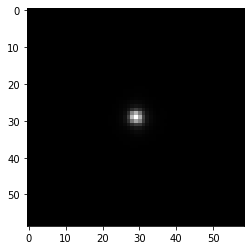

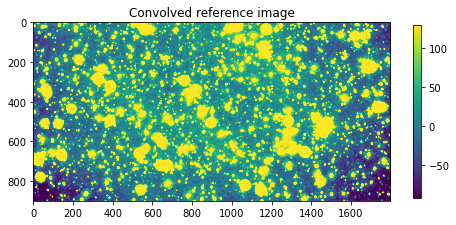

In [28]:
# Delete this step after the single image test is done!
# But check the steps after, since this was cut and pasted!

# use SCIENCE image to extract sources.
# overwriting the catalog, but I guess that doesn't matter much.

sci_image_bkgsub_name = sci_bkg_subtract_name # SWTICH when you go back to multi image!
#ref_image_bkgsub_name = os.path.join(proc_dir, bkg_subtract_array[len(bkg_subtract_array)-1])

if os.path.exists('prepsfex.cat'): #Remove possible temporary files
    os.remove("prepsfex.cat") 

try:
    #command = "sextractor %s -c %s -CATALOG_NAME %s -MAG_ZEROPOINT 25.0" % (sci_image_aligned_name, os.path.join(data_dir, 'prepsfex.sex'), os.path.join(proc_dir, 'prepsfex.cat'))
    #command = "source-extractor %s -c %s -CATALOG_NAME %s -MAG_ZEROPOINT 25.0" % (sci_image_aligned_name, os.path.join(data_dir, 'prepsfex.sex'), os.path.join(proc_dir, 'prepsfex.cat'))
    command = "source-extractor %s -c %s -CATALOG_NAME %s -MAG_ZEROPOINT 25.0" % (sci_image_bkgsub_name, os.path.join(data_dir,'prepsfex.sex'), os.path.join(proc_dir, 'prepsfex.cat'))
    print('Executing command: %s\n' % command)
    rval = subprocess.run(command.split(), check=True)
    print('Success!')
except subprocess.CalledProcessError as err:
    print('Could not run SExtractor with exit error %s'%err)
    
    
# Run PSFex to compute PSF, read and display the final model; needs to output to "out" dir.
if not os.path.isdir('out'): os.mkdir('out')

try:
    command = "psfex prepsfex.cat -c psfex_conf.psfex"
    #command = "psfex %s -c %s" % (source_extract_cat_name,psfex_config_name)
    print('Executing command: %s\n' % command)
    rval = subprocess.run(command.split(), check=True)
    print('Success!')
except subprocess.CalledProcessError as err:
    print('Could not run psfex with exit error %s'%err)

psf_sci_image_name = os.path.join(out_dir,'proto_prepsfex.fits') # temporary name?
print(psf_sci_image_name)
psf_sci_image = fits.open(psf_sci_image_name)

plt.imshow(psf_sci_image[0].data[0], cmap='gray')

# this is to be deleted when we move to multi images, but notice the science and ref images might be 
# switched below, incorrectly!

# Convolve the kernel of the SCIENCE images with the PSF of the reference frame
kernel_sci = psf_sci_image[0].data[0] # from the PSF we just did...

ref_bkg_subtract = fits.open(ref_bkg_subtract_name) # gross!
ref_conv = scipy_convolve(ref_bkg_subtract[0].data, kernel_sci, mode='same', method='fft') # convolve step
hdu_ref_conv = fits.PrimaryHDU(ref_conv,ref_bkg_subtract[0].header) 
ref_conv_name=os.path.join(proc_dir,ref_bkg_subtract_name.replace(".fits","_conv.fits"))
hdu_ref_conv.writeto(ref_conv_name,overwrite=True)

#Plot up the convolved reference image
mean, median, std = sigma_clipped_stats(hdu_ref_conv.data)
plt.figure(figsize=(8,8))

# set the scale of the image based on its statistics
plt.imshow(hdu_ref_conv.data, vmin=median-2*std, vmax=median+2*std)
plt.colorbar(shrink = 0.4)
plt.title('Convolved reference image')
plt.show()

Checking in AIJ, the resulting images have nearly the same PSF! (checking a few example sources, and they even seem to have the same pixel location values, which is good for us!

bright stars do have halos, which might be screwing up the background calculation, or the PSF? If we are eventually going to just subtract a circle, this might not matter.

In [29]:
'''
ref_conv_array=[]
for i in range(len(bkg_subtract_array)-1): # don't need to do the last one, that's the reference
    sci_image_bkgsub_name = os.path.join(proc_dir, bkg_subtract_array[i])

    try:
        command = "source-extractor %s -c %s -CATALOG_NAME %s -MAG_ZEROPOINT 25.0" % (sci_image_bkgsub_name, os.path.join(data_dir,'prepsfex.sex'), os.path.join(proc_dir, 'prepsfex.cat'))
        print('Executing command: %s\n' % command)
        rval = subprocess.run(command.split(), check=True)
        print('Success!')
    except subprocess.CalledProcessError as err:
        print('Could not run SExtractor with exit error %s'%err)
     
    # Run PSFex to compute PSF, read and display the final model; needs to output to "out" dir.
    if not os.path.isdir('out'): os.mkdir('out') # should be made already

    try:
        command = "psfex prepsfex.cat -c psfex_conf.psfex"
        print('Executing command: %s\n' % command)
        rval = subprocess.run(command.split(), check=True)
        print('Success!')
    except subprocess.CalledProcessError as err:
        print('Could not run psfex with exit error %s'%err)

    psf_sci_image_name = os.path.join(out_dir,'proto_prepsfex.fits') # DEFAULT name
    #psf_sci_image_name = os.path.join(out_dir,bkg_subtract_array[i].replace('.fits','_protoPSF.fits')) # rewriting each time!
    print(psf_sci_image_name)
    psf_sci_image = fits.open(psf_sci_image_name)
    # only the last image shows...
    plt.figure(figsize=(8,8))
    plt.imshow(psf_sci_image[0].data[0], cmap='gray')       
    plt.title('Science Image PSF')
    plt.show()   
        
    # Convolve the reference image with the PSF of each science frame
    # Grab the kernel!
    kernel_sci = psf_sci_image[0].data[0]
    
    # careful naming scheme needed!
    ref_bkg_subtract = fits.open(bkg_subtract_array[len(bkg_subtract_array)-1]) # REFERENCE IS LAST IMAGE!
    ref_conv = scipy_convolve(ref_bkg_subtract[0].data, kernel_sci, mode='same', method='fft') # convolve step
    hdu_ref_conv = fits.PrimaryHDU(ref_conv,ref_bkg_subtract[0].header) # really should be adding header keys!
    
    ref_conv_array.append(bkg_subtract_array[i].replace(".fits","_refconv.fits"))
    ref_conv_name=os.path.join(proc_dir,ref_conv_array[i])
    
    #ref_conv_name=os.path.join(proc_dir,bkg_subtract_array[i].replace(".fits","_refconv.fits"))
    
    
    # Images not being created!
    print(ref_conv_name)
    hdu_ref_conv.writeto(ref_conv_name,overwrite=True)

    #Plot up the convolved reference image
    mean, median, std = sigma_clipped_stats(hdu_ref_conv.data)
    plt.figure(figsize=(8,8))

    # set the scale of the image based on its statistics
    plt.imshow(ref_bkg_subtract[0].data, vmin=median-2*std, vmax=median+2*std)
    plt.colorbar(shrink = 0.4)
    plt.title('Convolved science image')
    plt.show()
'''    

'\nref_conv_array=[]\nfor i in range(len(bkg_subtract_array)-1): # don\'t need to do the last one, that\'s the reference\n    sci_image_bkgsub_name = os.path.join(proc_dir, bkg_subtract_array[i])\n\n    try:\n        command = "source-extractor %s -c %s -CATALOG_NAME %s -MAG_ZEROPOINT 25.0" % (sci_image_bkgsub_name, os.path.join(data_dir,\'prepsfex.sex\'), os.path.join(proc_dir, \'prepsfex.cat\'))\n        print(\'Executing command: %s\n\' % command)\n        rval = subprocess.run(command.split(), check=True)\n        print(\'Success!\')\n    except subprocess.CalledProcessError as err:\n        print(\'Could not run SExtractor with exit error %s\'%err)\n     \n    # Run PSFex to compute PSF, read and display the final model; needs to output to "out" dir.\n    if not os.path.isdir(\'out\'): os.mkdir(\'out\') # should be made already\n\n    try:\n        command = "psfex prepsfex.cat -c psfex_conf.psfex"\n        print(\'Executing command: %s\n\' % command)\n        rval = subprocess.ru

In [30]:
'''
ref_conv_array
'''

'\nref_conv_array\n'

These guys now DO have WCS headers.

(I think this step should go inside the normalization loop somewhere, so skipping to that...)

### Improving the alignment
Now that the science image is convolved with (an approximation of) the PSF of the reference image, 
and the reference image is convolved with the PSF of the science image, we can perform the image subtraction.

- Before the subtraction we use an fft method (chi_2_shift) to fine-tune the image alignment of the reference and science image. We'll do this in pairs, reference aligning with science. When we go do photometry with AIJ, this fine tuning doesn't matter so much.

## Normalization of the images

The science and reference images are usually obtained with different exposure times.  In addition, the reference image can be the stack of several images to increase the depth.  Finally, different CCDs of the same camera (or even different regions of the same CCD when multiple amplifiers are present) may have slightly different gain. <br >

The background subtraction should have removed the non-linear offsets between science and reference images.  We can therefore normalize the two images by computing the ratio of bright star fluxes in the two images. Once again, we use SExtractor to extract the flux and other quantities.

We should be able to do this pairwise as well, as the offsets between different science images should be taken care of with our differential photometry. So we'll maybe normalize the reference(s) to the science?

/home/cduston/GoogleDrive/Research/MCARG/Novae/SN2023ctn/image_subtraction/processed/SUM_Aligned_20230308_I_bkgsub_conv.fits
/home/cduston/GoogleDrive/Research/MCARG/Novae/SN2023ctn/image_subtraction/processed/SUM_Aligned_20240119_I_bkgsub_conv.fits
Executing command: source-extractor /home/cduston/GoogleDrive/Research/MCARG/Novae/SN2023ctn/image_subtraction/processed/SUM_Aligned_20230308_I_bkgsub_conv.fits -c prepsfex.sex -CATALOG_NAME sci_match.cat -MAG_ZEROPOINT 25.0 -CATALOG_TYPE=ASCII_HEAD

Success!
Executing command: source-extractor /home/cduston/GoogleDrive/Research/MCARG/Novae/SN2023ctn/image_subtraction/processed/SUM_Aligned_20240119_I_bkgsub_conv.fits -c prepsfex.sex -CATALOG_NAME ref_match.cat -MAG_ZEROPOINT 25.0 -CATALOG_TYPE=ASCII_HEAD

Success!
The scaling factor is 0.572156446409146


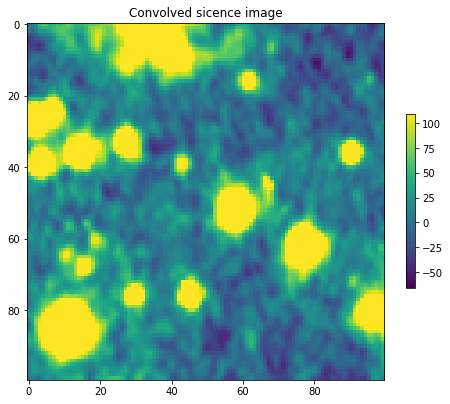

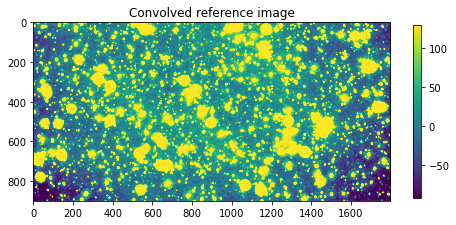

Alignment offsets: 0.951171875 -1.869140625


902.2817902857234 451.80113952475205


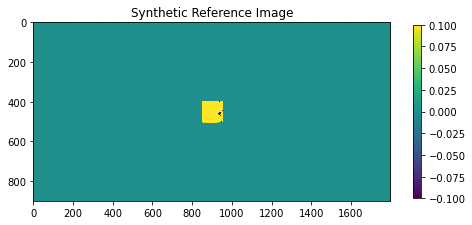

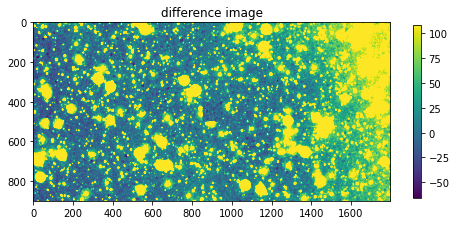

In [59]:
# Remove this block once the single-image test is done!

# Run SExtractor on the science image
print(sci_conv_name)
print(ref_conv_name)
    
sextractor_command = "source-extractor %s -c prepsfex.sex -CATALOG_NAME sci_match.cat -MAG_ZEROPOINT 25.0 -CATALOG_TYPE=ASCII_HEAD" % (sci_conv_name)

try:
    command = sextractor_command
    print('Executing command: %s\n' % command)
    rval = subprocess.run(command.split(), check=True)
    print('Success!')
except subprocess.CalledProcessError as err:
    print('Could not run SExtractor with exit error %s'%err)

cat_sci = ascii.read('sci_match.cat') # dummy, should be able to rewrite constantly
    
# Run SExtractor on the reference image
sextractor_command = "source-extractor %s -c prepsfex.sex -CATALOG_NAME ref_match.cat -MAG_ZEROPOINT 25.0 -CATALOG_TYPE=ASCII_HEAD" % (ref_conv_name)

try:
    command = sextractor_command
    print('Executing command: %s\n' % command)
    rval = subprocess.run(command.split(), check=True)
    print('Success!')
except subprocess.CalledProcessError as err:
    print('Could not run SExtractor with exit error %s'%err)

# Read in the SExtractor output catalog
cat_ref = ascii.read('ref_match.cat')
    
# Match the catalog of sources of the reference and science images.  
# Calculate the ratio between the flux of source in the science image over the flux of sources 
# in the reference image.
    
c_sci = SkyCoord(ra=cat_sci['X_WORLD'], dec=cat_sci['Y_WORLD'])
c_ref = SkyCoord(ra=cat_ref['X_WORLD'], dec=cat_ref['Y_WORLD'])

idx, d2d, d3d = c_sci.match_to_catalog_3d(c_ref)

# Initialize a list for the indexes and one for the flux ratios
# for each (sci, ref) pair, don't need to save all this?
index_arr = []
ratio_arr = []

# Sure don't need to be printing all this stuff! Is there a final normalization i can use for checking?
for j, i2, d in zip(idx, np.arange(len(d2d)),d2d):
    #print(i,d)
    #index_arr.append(i)
    #print("Image coordinates")
    #print(cat_ref['X_IMAGE'][i],cat_ref['Y_IMAGE'][i],'  ', cat_sci['X_IMAGE'][i2],cat_sci['Y_IMAGE'][i2])
    #print('Fluxes and flux ratio')
    #print(cat_ref['FLUX_AUTO'][i], cat_sci['FLUX_AUTO'][i2], cat_sci['FLUX_AUTO'][i2] / cat_ref['FLUX_AUTO'][i])
    ratio_arr.append(cat_sci['FLUX_AUTO'][i2] / cat_ref['FLUX_AUTO'][j]) # Ratio of SCI/REF!
    
scale = np.median(ratio_arr)
print("The scaling factor is", scale)
    
# fine tune the alignment here - at least without this, the alginment is terrible!
# this line might need to include rotation...
sci_image = fits.open(sci_conv_name)
ref_image = fits.open(ref_conv_name)
## Check the images...set the scale of the image based on its statistics
mean, median, std = sigma_clipped_stats(sci_image[0].data)
plt.figure(figsize=(8,8))
plt.imshow(sci_image[0].data[200:300,200:300], vmin=median-2*std, vmax=median+2*std)
plt.colorbar(shrink = 0.4)
plt.title('Convolved sicence image')
plt.show()
mean, median, std = sigma_clipped_stats(ref_image[0].data)
plt.figure(figsize=(8,8))
plt.imshow(ref_image[0].data, vmin=median-2*std, vmax=median+2*std)
plt.colorbar(shrink = 0.4)
plt.title('Convolved reference image')
plt.show()
# They look right!

xoff, yoff, exoff, eyoff = chi2_shift(ref_image[0].data, sci_image[0].data, 10, return_error=True, upsample_factor='auto')
print("Alignment offsets:",xoff,yoff)
sci_image_shift = scipy.ndimage.shift(sci_image[0].data, [-yoff, -xoff], order=3, mode='reflect', cval=0.0, prefilter=True)
    
# Rescale the reference image to the science and perform the image subtraction.

# first convert the source coordinates to pixel...
RA=128.249
Dec=-27.449311
from astropy.coordinates import SkyCoord
#coord = SkyCoord('00h00m00s +00d00m00s', frame='galactic')
coord = SkyCoord(RA,Dec,unit='deg')
w = WCS(sci_image[0].header)
x, y = w.world_to_pixel(coord)
print(x,y)
size=50
synthetic_image=np.zeros(sci_image[0].data.shape)
synthetic_image[int(y)-size:int(y)+size,int(x)-size:int(x)+size]=ref_image[0].data[int(y)-size:int(y)+size,int(x)-size:int(x)+size]

# Plot synthetic image
mean, median, std = sigma_clipped_stats(synthetic_image)
plt.figure(figsize=(8,8))
plt.imshow(synthetic_image, vmin=median-2*std, vmax=median+2*std)
plt.colorbar(shrink = 0.4)
plt.title('Synthetic Reference Image')
plt.show()

#image_sub = sci_image_shift-ref_image[0].data*scale
image_sub = sci_image_shift-synthetic_image*scale
hdu_image_sub = fits.PrimaryHDU(image_sub) # needs a header!
#sub_array.append(sci_conv_name.replace(".fits","_diff.fits")) # move to the out directory
hdu_image_sub.writeto(sci_conv_name.replace(".fits","_diff.fits"),overwrite=True)

## Check the images...set the scale of the image based on its statistics
mean, median, std = sigma_clipped_stats(image_sub)
plt.figure(figsize=(8,8))
plt.imshow(image_sub, vmin=median-2*std, vmax=median+2*std)
plt.colorbar(shrink = 0.4)
plt.title('difference image')
plt.show()

902.2817902857234 451.80113952475205


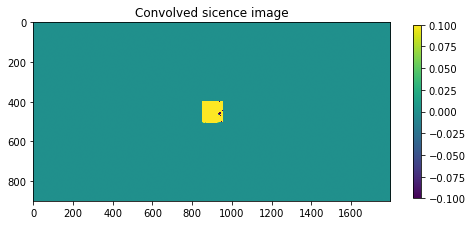

In [58]:
# first convert the source coordinates to pixel...
RA=128.249
Dec=-27.449311
from astropy.coordinates import SkyCoord
#coord = SkyCoord('00h00m00s +00d00m00s', frame='galactic')
coord = SkyCoord(RA,Dec,unit='deg')
w = WCS(sci_image[0].header)
x, y = w.world_to_pixel(coord)
print(x,y)
size=50
sci_image[0].data.shape
synthetic_image=np.zeros(sci_image[0].data.shape)
synthetic_image.shape
#synthetic_image = np.zeros([sci_image[0].header['NAXIS1'],sci_image[0].header['NAXIS2']])
#synthetic_image.shape()
synthetic_image[int(y)-size:int(y)+size,int(x)-size:int(x)+size]=ref_image[0].data[int(y)-size:int(y)+size,int(x)-size:int(x)+size]

# Plot synthetic image
mean, median, std = sigma_clipped_stats(synthetic_image)
plt.figure(figsize=(8,8))
plt.imshow(synthetic_image, vmin=median-2*std, vmax=median+2*std)
plt.colorbar(shrink = 0.4)
plt.title('Convolved sicence image')
plt.show()

Ok, for this version - the subtraction acftually might reveal the SN near the middle of the image. I think the next thing to do it just as much as possible with cropped images.

No - but notice how the errors are different on different sides of the image? It's a rotation problem, probably from the very beginning! Even using two science images, the shift is bad. Doesn't look as bad as with the reference, but still pretty bad. Is the rotation script bad? Worked on the rotation a bit - maybe you just can't subtract images this big, you'll always have strange shifting?

Thinking a little more carefully - the WCS doesn't guarantee that the subtraction is done at the coordinate level, right? It tell you how to convert to (RA,Dec) as you move around the image, but if the image has distortions at the pixel level, the subtraction is *never* going to look that great.

Solution: Reduce the size of the subtractioned section!

In [ ]:
'''
sub_array=[]
for i in range(len(bkg_subtract_array)-1): # don't need to do the last one, that's the reference
    
    # Run SExtractor on the science image
    sextractor_command = "source-extractor %s -c prepsfex.sex -CATALOG_NAME sci_match.cat -MAG_ZEROPOINT 25.0 -CATALOG_TYPE=ASCII_HEAD" % (sci_conv_array[i])

    try:
        command = sextractor_command
        print('Executing command: %s\n' % command)
        rval = subprocess.run(command.split(), check=True)
        print('Success!')
    except subprocess.CalledProcessError as err:
        print('Could not run SExtractor with exit error %s'%err)

    cat_sci = ascii.read('sci_match.cat') # dummy, should be able to rewrite constantly
    
    # Run SExtractor on the reference image
    sextractor_command = "source-extractor %s -c prepsfex.sex -CATALOG_NAME ref_match.cat -MAG_ZEROPOINT 25.0 -CATALOG_TYPE=ASCII_HEAD" % (ref_conv_array[i])

    try:
        command = sextractor_command
        print('Executing command: %s\n' % command)
        rval = subprocess.run(command.split(), check=True)
        print('Success!')
    except subprocess.CalledProcessError as err:
        print('Could not run SExtractor with exit error %s'%err)

    # Read in the SExtractor output catalog
    cat_ref = ascii.read('ref_match.cat')
    
    # Match the catalog of sources of the reference and science images.  
    # Calculate the ratio between the flux of source in the science image over the flux of sources 
    # in the reference image.
    
    # Getting lattitude angles of like 800 degrees, so something is wrong with the WCS.
    # Confirmed, these images do not have WCS! which ones still do....
    # bgsub do not...
    # Rotated do not! That's gotta be it...
    
    
    c_sci = SkyCoord(ra=cat_sci['X_WORLD'], dec=cat_sci['Y_WORLD'])
    c_ref = SkyCoord(ra=cat_ref['X_WORLD'], dec=cat_ref['Y_WORLD'])

    idx, d2d, d3d = c_sci.match_to_catalog_3d(c_ref)

    # Initialize a list for the indexes and one for the flux ratios
    # for each (sci, ref) pair, don't need to save all this?
    index_arr = []
    ratio_arr = []

    # Sure don't need to be printing all this stuff! Is there a final normalization i can use for checking?
    for j, i2, d in zip(idx, np.arange(len(d2d)),d2d):
        #print(i,d)
        #index_arr.append(i)
        #print("Image coordinates")
        #print(cat_ref['X_IMAGE'][i],cat_ref['Y_IMAGE'][i],'  ', cat_sci['X_IMAGE'][i2],cat_sci['Y_IMAGE'][i2])
        #print('Fluxes and flux ratio')
        #print(cat_ref['FLUX_AUTO'][i], cat_sci['FLUX_AUTO'][i2], cat_sci['FLUX_AUTO'][i2] / cat_ref['FLUX_AUTO'][i])
        ratio_arr.append(cat_sci['FLUX_AUTO'][i2] / cat_ref['FLUX_AUTO'][j]) # Ratio of SCI/REF!
    
    scale = np.median(ratio_arr)
    print("The scaling factor is", scale)
    
    # fine tune the alignment here - at least without this, the alginment is terrible!
    sci_image = fits.open(sci_conv_array[i])
    ref_image = fits.open(ref_conv_array[i])
    xoff, yoff, exoff, eyoff = chi2_shift(sci_image[0].data, ref_image[0].data, 10, return_error=True, upsample_factor='auto')
    print("Alignment offsets:",xoff,yoff)
    ref_image_shift = scipy.ndimage.shift(ref_image[0].data, [-yoff, -xoff], order=3, mode='reflect', cval=0.0, prefilter=True)
    
    # Rescale the reference image to the science and perform the image subtraction.
    image_sub = sci_image[0].data-ref_image_shift*scale
    hdu_image_sub = fits.PrimaryHDU(image_sub) # needs a header!
    sub_array.append(sci_conv_array[i].replace(".fits","_diff.fits")) # move to the out directory
    hdu_image_sub.writeto("out/"+sub_array[i],overwrite=True)
'''

they do not look great, let's plot to evaluate more closely.

In [ ]:
fig, axs = plt.subplots(len(bkg_subtract_array)-1, 2,figsize=(50,50))
for i in range(len(bkg_subtract_array)-1):
    sci_image = fits.open(sci_conv_array[i])
    sub_image = fits.open(sub_array[i])
    
    mean, median, std = sigma_clipped_stats(sub_image[0].data)
    axs[i,0].imshow(sub_image[0].data[600:1200,600:1200], vmin=median-2*std, vmax=median+2*std, cmap='gray')
        
    mean, median, std = sigma_clipped_stats(sci_image[0].data)
    axs[i,1].imshow(sci_image[0].data[600:1200,600:1200], vmin=median-2*std, vmax=median+2*std, cmap='gray')

 Well the galaxy seems to have disappeared, but the PSF matching certainly does not look great. 
 
 "Not algined" is my diagnoses.